NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

In [2]:
# Installing required packages
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 38.7 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [4]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
roboflow_project_name = 'stormdamagechallenge'
dataset_name = 'storm-damage'
dataset_title = 'Storm-Damage'
dataset_id = 'goe2a'
dataset_version = 4
model_name = 'yolo'
model_version = '11' # '8v' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace(roboflow_project_name).project(dataset_name + '-' + dataset_id)
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolo11 in progress : 85.0%
Version export complete for yolo11 format



Extracting Dataset Version Zip to Storm-Damage-4 in yolo11:: 100%|██████████| 1090/1090 [00:00<00:00, 6609.74it/s]


### Import remaining packages

In [5]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Check the version of Ultralytics

In [6]:
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [8]:
!nvidia-smi

Sun Dec 22 18:15:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading YOLO model for Training


In [9]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

100%|██████████| 5.35M/5.35M [00:00<00:00, 292MB/s]


YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

### Training Model

In [10]:
yaml_file = f'{HOME}/{dataset_title}-{dataset_version}/data.yaml'
yaml_file

'/content/Storm-Damage-4/data.yaml'

#### Resume model training from last step (optional)

In [ ]:
# Resuming model training from last completed epoch
# model = YOLO('last.pt')

In [11]:
# Define model training parameters
batch = -1 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 30
patience = 5
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}_' # run directory name

In [12]:
# Train the model
model.train(data=yaml_file, batch = batch, device = device, epochs = epochs, patience = patience, imgsz = imgsz, plots = plots, project = project, name = name_train)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolo11/yolo11n.pt, data=/content/Storm-Damage-4/data.yaml, epochs=30, time=None, patience=5, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=yolo11n_training_dataset_v4_, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 96.6MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 254MB/s]


AMP: checks passed ✅


train: Scanning /content/Storm-Damage-4/train/labels... 453 images, 258 backgrounds, 0 corrupt: 100%|██████████| 453/453 [00:00<00:00, 2059.18it/s]

train: New cache created: /content/Storm-Damage-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.10G reserved, 0.06G allocated, 14.59G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590230       6.442         0.371         76.05         449.9        (1, 3, 640, 640)                    list
     2590230       12.88         0.518         32.01         68.34        (2, 3, 640, 640)                    list
     2590230       25.77         0.820         34.77         58.87        (4, 3, 640, 640)                    list
     2590230       51.53         1.472         38.18         65.89        (8, 3, 640, 640)                    list
     2590230       103.1         2.

train: Scanning /content/Storm-Damage-4/train/labels.cache... 453 images, 258 backgrounds, 0 corrupt: 100%|██████████| 453/453 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Storm-Damage-4/valid/labels... 66 images, 20 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<00:00, 1276.38it/s]

val: New cache created: /content/Storm-Damage-4/valid/labels.cache


Plotting labels to exploratory_phase/yolo11n_training_dataset_v4_/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000703125), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to exploratory_phase/yolo11n_training_dataset_v4_
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30        15G       2.14      3.814      1.712         66        640: 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]

                   all         66       1114    0.00759      0.226     0.0104    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      14.3G      1.808      3.513      1.451          8        640: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         66       1114     0.0129      0.337     0.0322     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      15.6G      1.622      3.354      1.234          2        640: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         66       1114     0.0315      0.693      0.156     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      14.3G      1.708      2.161      1.275         21        640: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         66       1114     0.0317      0.696      0.231     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      14.9G      1.441      14.65      1.084          0        640: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         66       1114     0.0218      0.558      0.181     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      15.5G      1.675      1.764      1.287         59        640: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         66       1114      0.024      0.561      0.155     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      14.1G      1.372      10.72      1.048          0        640: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         66       1114     0.0261      0.552       0.15     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      14.9G      1.602      1.558      1.266         25        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all         66       1114      0.663      0.127      0.226     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      14.2G      1.581      1.391      1.201         34        640: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         66       1114      0.648     0.0858      0.348      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      14.1G      1.599      1.407      1.261         20        640: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         66       1114      0.491      0.451       0.42      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      15.4G       1.57       1.48      1.246         32        640: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         66       1114      0.597      0.132      0.125     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30        14G      1.602      1.479      1.301         47        640: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all         66       1114      0.585      0.132      0.136     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      14.5G      1.636      1.447      1.293         56        640: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         66       1114      0.655     0.0882      0.116      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30        15G      1.755      1.738      1.322          9        640: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         66       1114      0.626      0.121      0.268     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      13.7G      1.512      1.321      1.226         13        640: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         66       1114      0.507        0.4      0.425      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      13.3G      1.588      1.725      1.319          5        640: 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         66       1114      0.531       0.45      0.476      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      15.3G      1.495      1.193      1.202         23        640: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         66       1114      0.609      0.462      0.502      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      15.2G        1.5      1.223       1.22         41        640: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         66       1114      0.523      0.418       0.44      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      14.2G      1.526      1.262      1.255         31        640: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         66       1114      0.477      0.437      0.441      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      14.5G        1.5       1.15      1.197         61        640: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         66       1114      0.622      0.597      0.604      0.284


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      14.7G      1.461      1.257      1.212         16        640: 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         66       1114      0.498        0.4      0.393      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.9G      1.455      1.268      1.181         10        640: 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         66       1114      0.542       0.54      0.535      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.9G      1.474      1.599      1.205          2        640: 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         66       1114       0.46      0.514      0.411      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      14.2G      1.353      1.502      1.106          3        640: 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         66       1114      0.476      0.423      0.409      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.6G      1.143      4.051      0.969          0        640: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         66       1114      0.562      0.501      0.498      0.218
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



25 epochs completed in 0.075 hours.
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v4_/weights/last.pt, 5.5MB
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v4_/weights/best.pt, 5.5MB

Validating exploratory_phase/yolo11n_training_dataset_v4_/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


                   all         66       1114      0.623      0.596      0.604      0.284
undamagedcommercialbuilding         33        204      0.483      0.422      0.398      0.201
undamagedresidentialbuilding         30        910      0.763      0.771       0.81      0.366
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v4_


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79295c1d06d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

/content


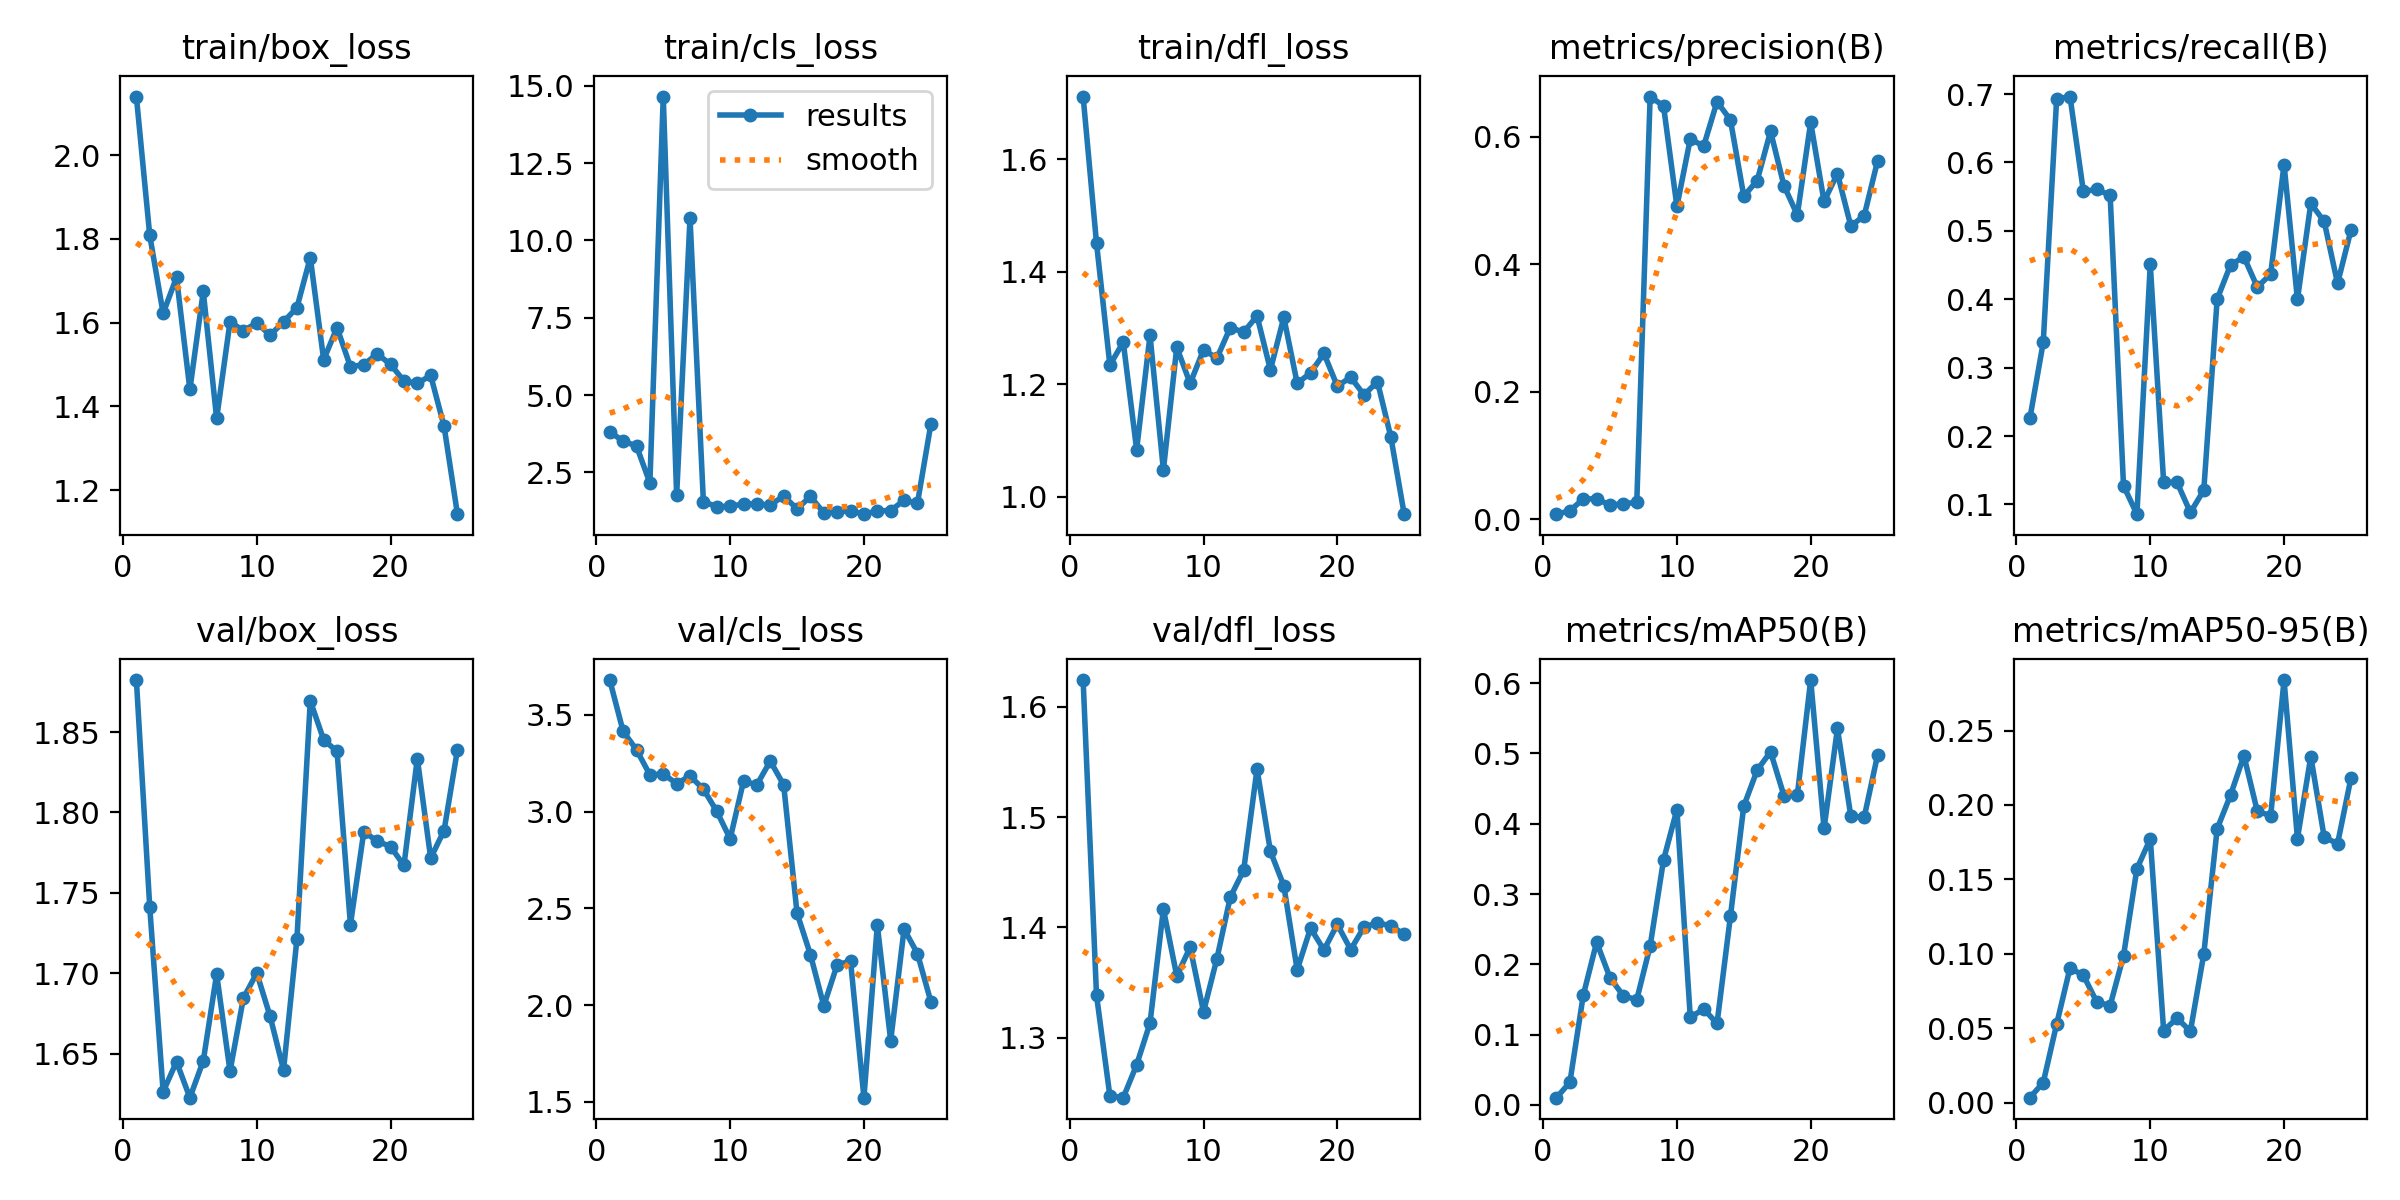

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


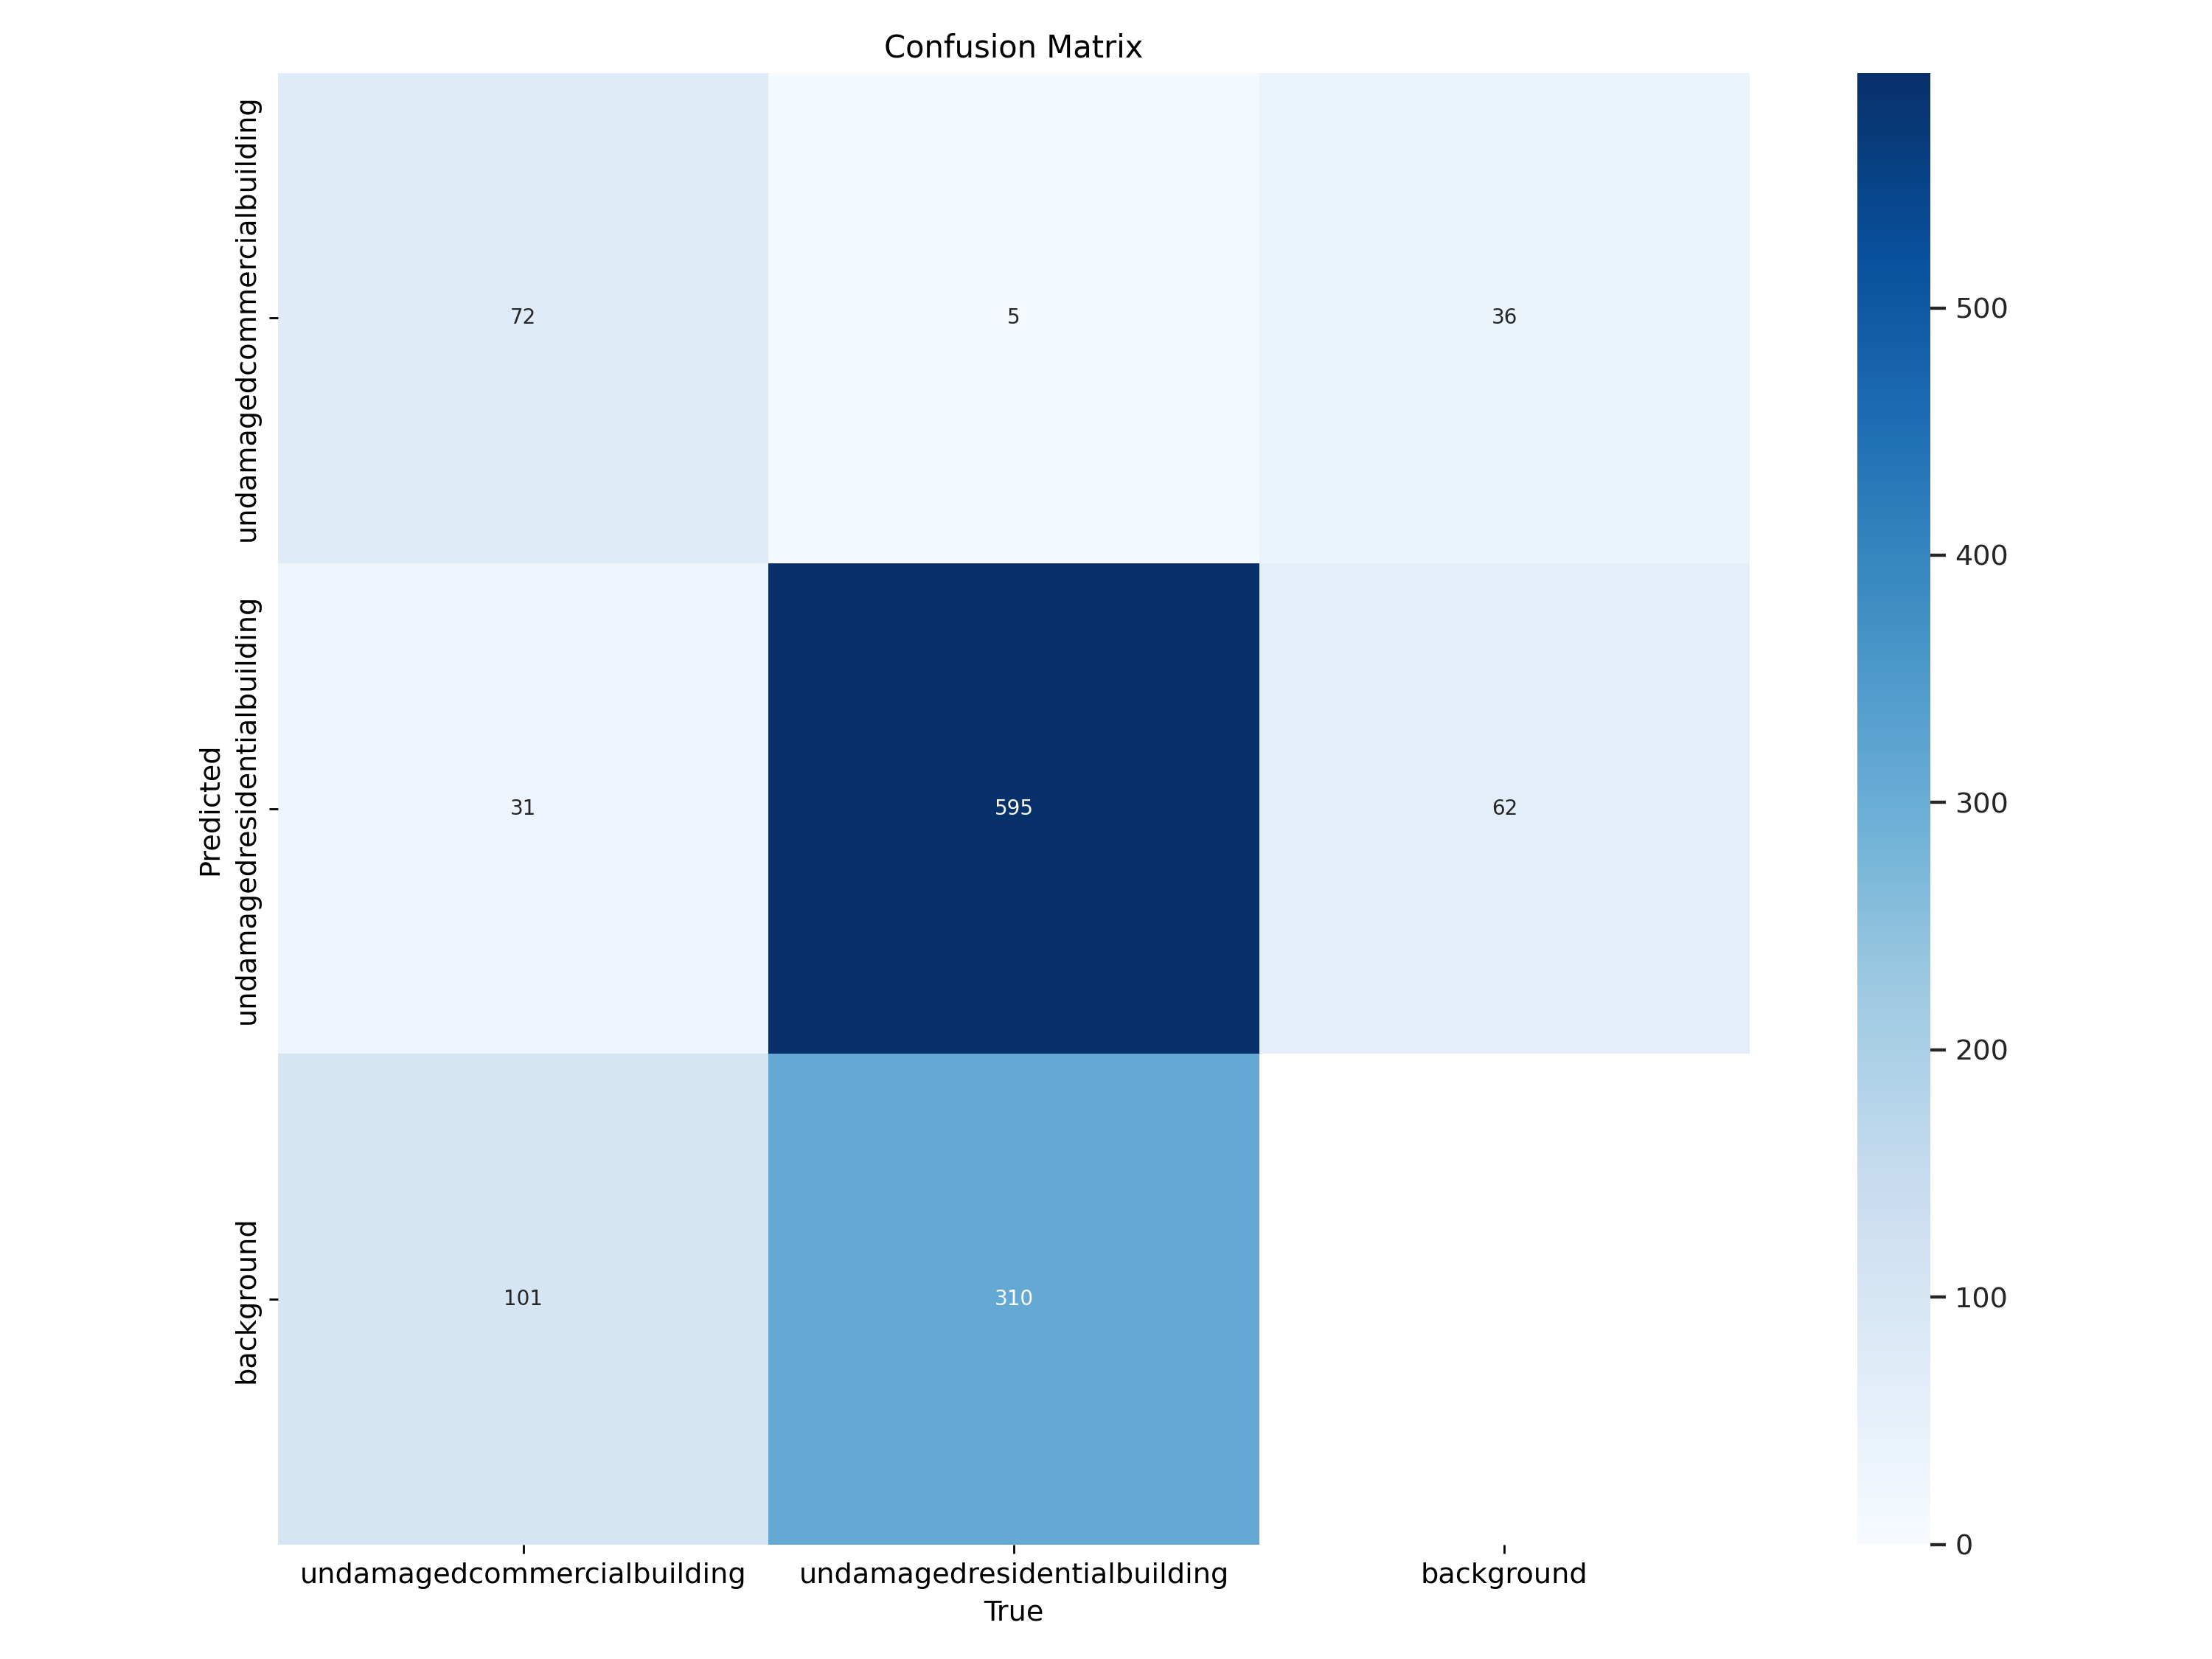

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix.png', width=600)

/content


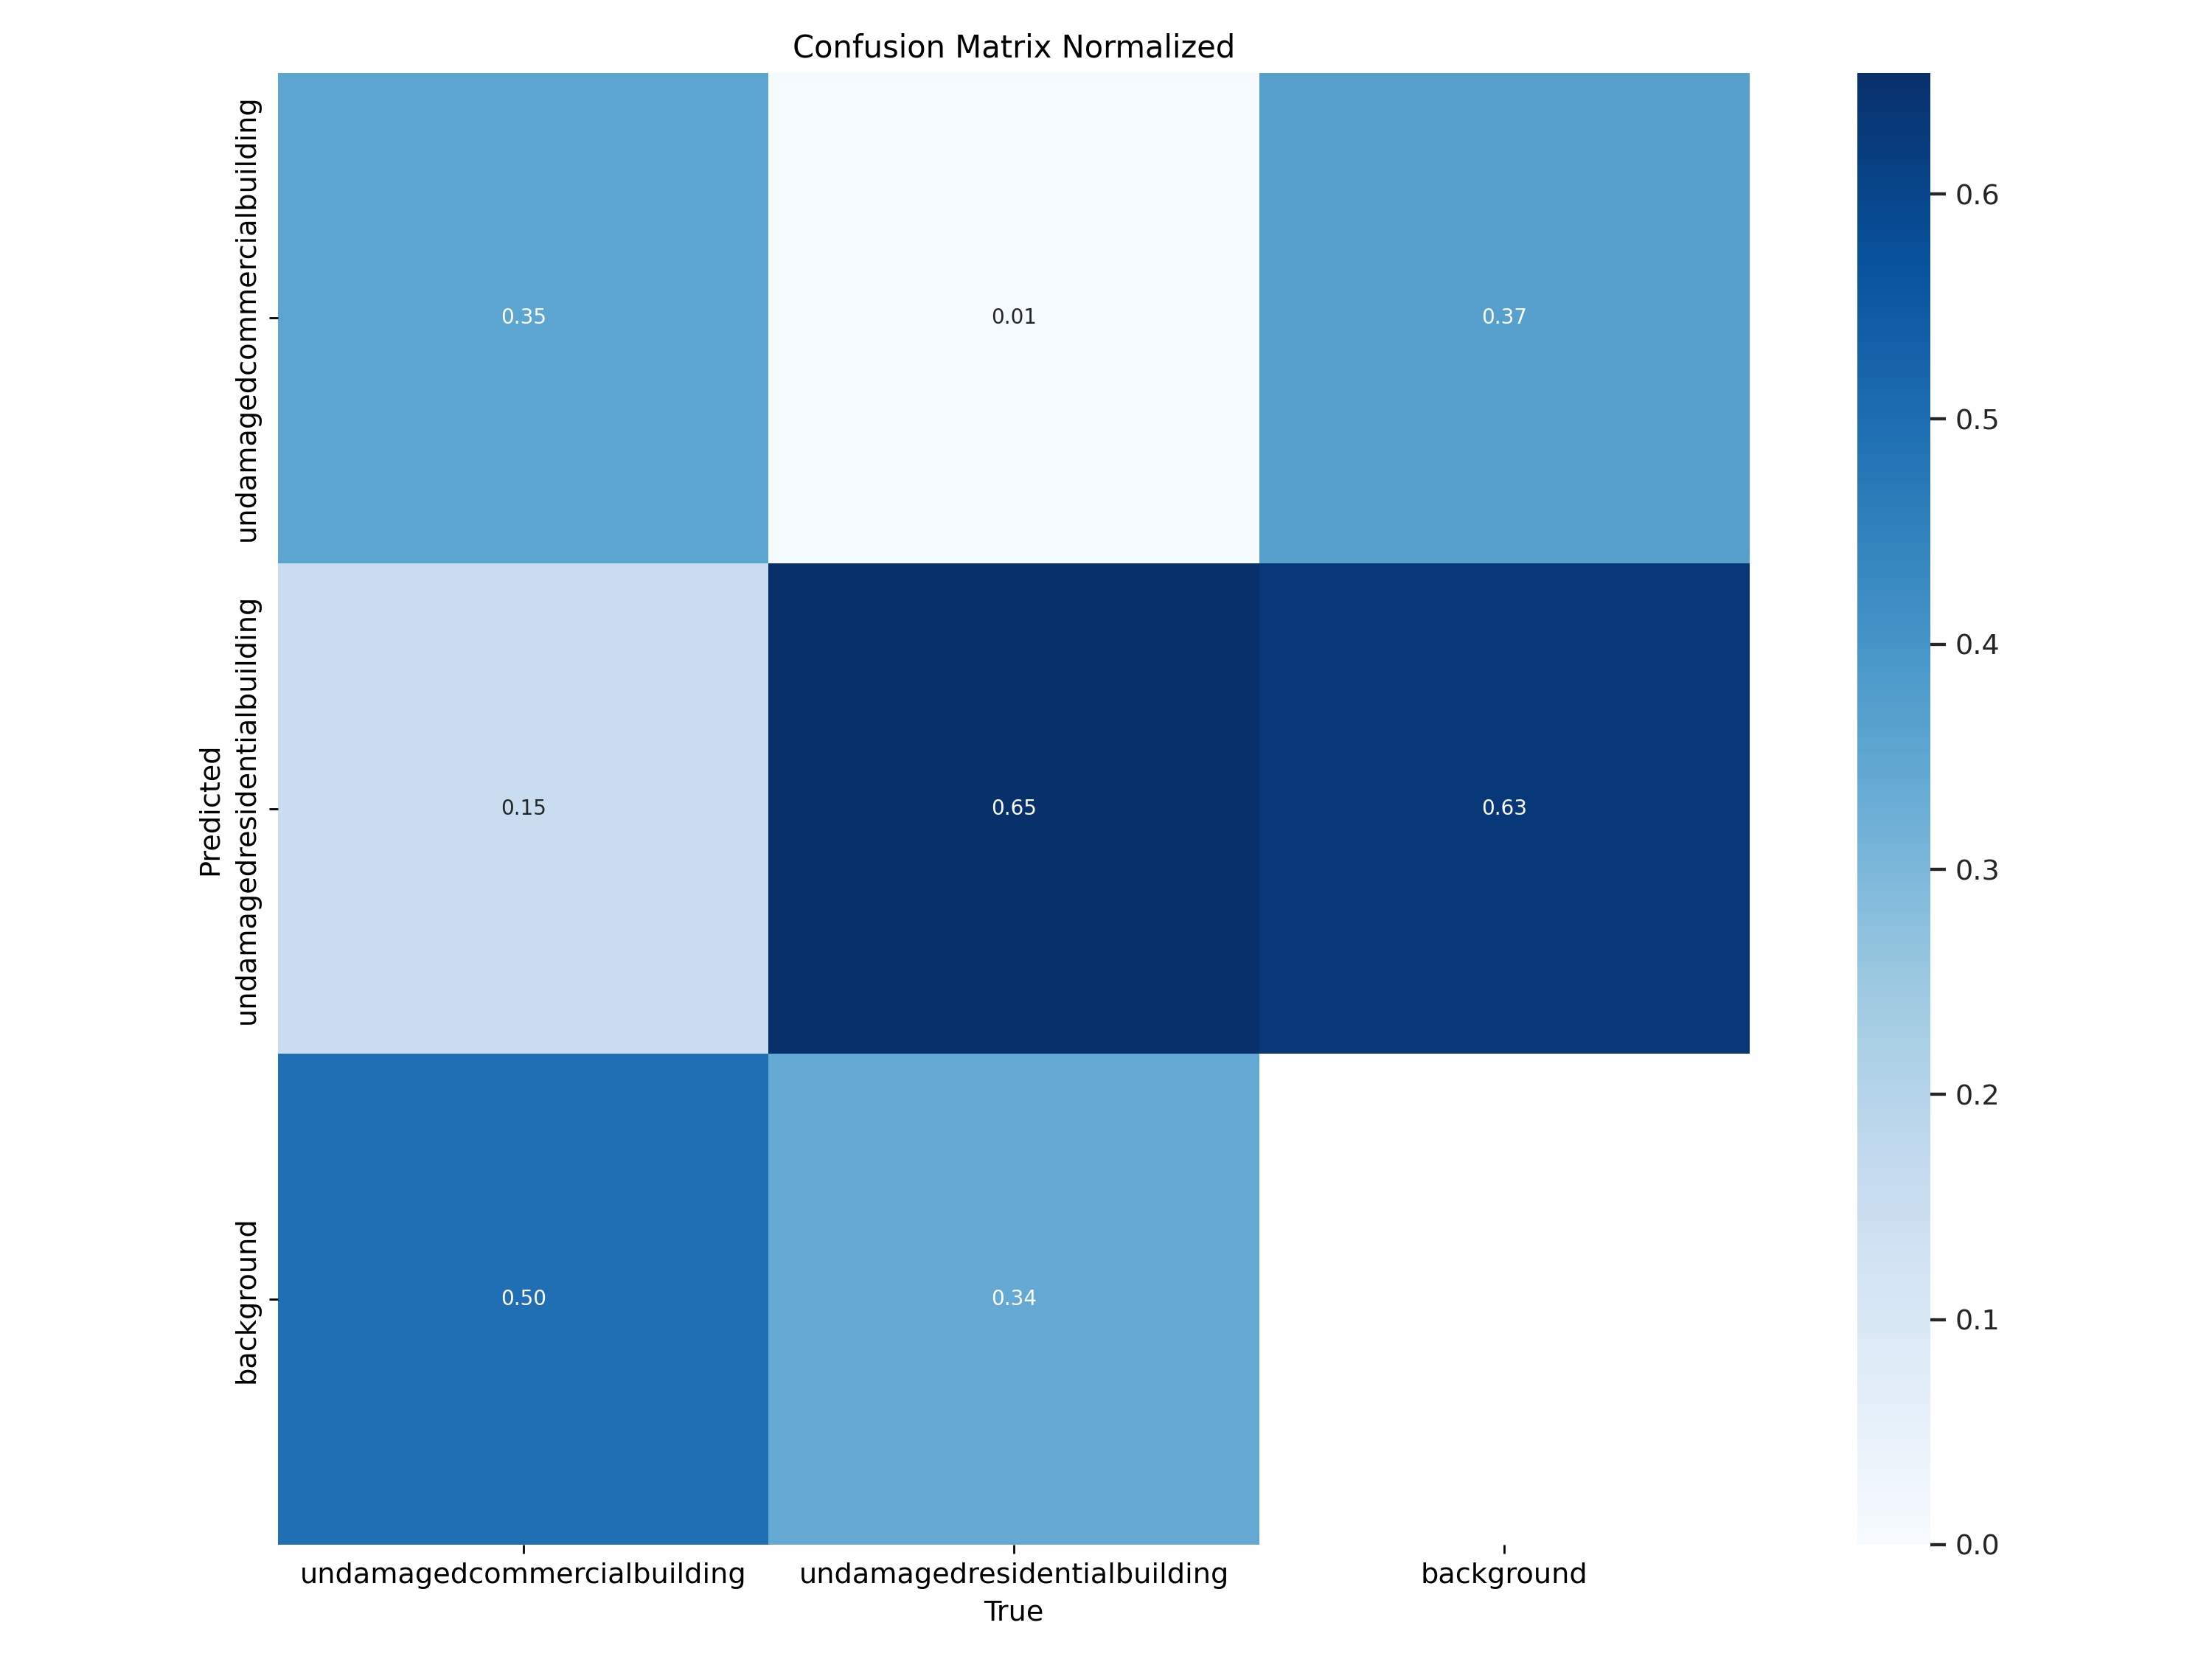

In [16]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [18]:
# Load the model from the best training weights (Note: select path of the "best.pt" file)
path_to_weights_best = f"/{HOME}/{project}/{name_train}/weights/best.pt"
# /content/exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt
model = YOLO(path_to_weights_best)

In [19]:
# Evaluate model metrics on the "test" dataset split
split_test = 'test'
name_metrics_test = f'metrics_{split_test}' # Directory name for saving results
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_test, project=project, name=name_metrics_test)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Storm-Damage-4/test/labels... 20 images, 16 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 3071.63it/s]

val: New cache created: /content/Storm-Damage-4/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


                   all         20        174      0.645      0.658       0.63      0.335
undamagedcommercialbuilding          3          8      0.429       0.75      0.544       0.28
undamagedresidentialbuilding          4        166      0.862      0.566      0.716       0.39
Speed: 0.3ms preprocess, 20.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to exploratory_phase/metrics_test


In [20]:
# Load the model from the best training weights
split_val = 'val'
name_metrics_val = f'metrics_{split_val}' # Directory name for saving results
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_val, project=project, name=name_metrics_val)

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/Storm-Damage-4/valid/labels.cache... 66 images, 20 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


                   all         66       1114      0.736      0.488      0.611      0.321
undamagedcommercialbuilding         33        204      0.627      0.338      0.477      0.268
undamagedresidentialbuilding         30        910      0.846      0.638      0.746      0.374
Speed: 0.5ms preprocess, 20.2ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to exploratory_phase/metrics_val


In [21]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print(f"Below, comparison of evaluation metrics on dataset splits \'{split_test}\' and \'{split_val}\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model '11n' trained on dataset 'storm-damage-version4'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.27978     0.39024]
Val dataset - mAP of each class: [    0.26823     0.37427]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3350125324254318
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.3212520205089856
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6298291492460126
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6114151101434464


## Downloading Results (.zip file)

In [ ]:
from google.colab import files

# Define download parameters and file names
path_dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v4' #@param {type: "string"}
output_filename = 'yolo11n_training_dataset_v4.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system("zip -r {} {}".format(output_filename, path_dir_to_zip))
# Download file to local machine
files.download(output_filename)
# Delete the created zip file (optional)
if delete_zip_file_after_download == "Yes":
    os.system("rm -r {}".format(path_zip_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name